In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Color and exposure

As discussed earlier, images are just numpy arrays. The numbers in those arrays correspond to the intensity of each pixel (or, in the case of a color image, the intensity of a specific color). To manipulate these, `scikit-image` provides the `color` and `exposure` modules.

## Basic image manipulation

Recall that color images are arrays with pixel rows and columns as the first two dimensions (just like a gray-scale image), plus a 3rd dimension that describes the RGB color channels.

(300, 451, 3)


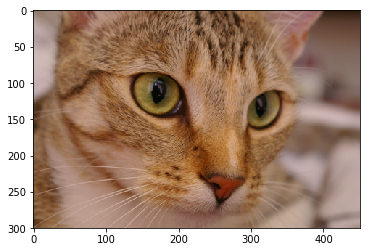

In [2]:
from skimage import data

color_image = data.chelsea()

print(color_image.shape)
plt.imshow(color_image);

### Slicing and indexing

Since images are just arrays, we can manipulate them as we would any other array.

Let's say we want to plot just the red channel of the color image above. We know that the red channel is the first channel of the 3rd image-dimension. Since Python is zero-indexed, we can write the following:

In [3]:
red_channel = color_image[:, :, 0]  # or color_image[..., 0]

But when we plot the red channel...

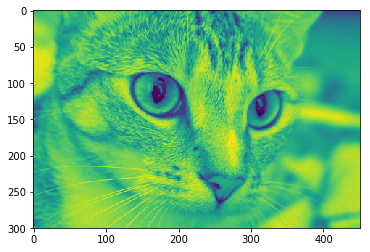

In [4]:
plt.imshow(red_channel);

Obviously that's not red at all. The reason is that there's nothing to tell us that this array is supposed to be red: It's just a 2D array with a height, width, and intensity value---and no color information.

The green channel is usually closest to the grey-scale version of the image.  Note that converting to grayscale cannot simply be done by taking the mean of the three channels, since the eye is more sensitive to green than to red than to blue.  For that purpose, use ``skimage.color.rgb2gray``, which weighs each channel appropriately.

In [5]:
red_channel.shape

(300, 451)

The shape of this array is the same as it would be for any gray-scale image.

---

## <span class="exercize">Exercise: three colours</span>

Consider the following image (``images/balloon.jpg``):

<img src="../images/balloon.jpg"/>

Split this image up into its three components, red, green and blue, and display each separately.

HINT: To display multiple images, we provide you with a small utility library called ``skdemo``:

```python
import skdemo
skdemo.imshow_all(image0, image1, image2, ...)
```

Or, simply use ``matplotlib.subplots``:

```python
plt, axes = plt.subplots(1, 4)
axes[0].imshow(image0)
axes[1].imshow(image1)
etc.
```

In [6]:
from skimage import io
color_image = io.imread('../images/balloon.jpg')

In [7]:
import skdemo
#skdemo.  # <TAB>

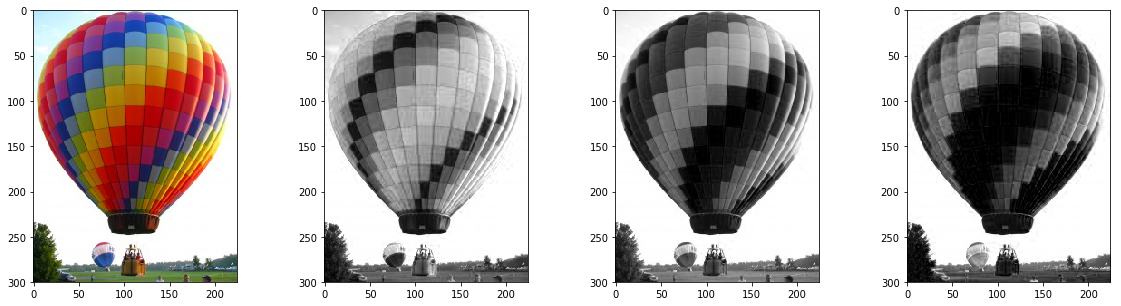

In [9]:
# This code is just a template to get you started.
red_image = color_image[:,:,0] #np.zeros_like(color_image)
green_image = color_image[:,:,1] #np.zeros_like(color_image)
blue_image = color_image[:,:,2] #np.zeros_like(color_image)

skdemo.imshow_all(color_image, red_image, green_image, blue_image)

---

#### Combining color-slices with row/column-slices

In the examples above, we just manipulate the last axis of the array (i.e. the color channel). As with any NumPy array, however, slicing can be applied to each axis:

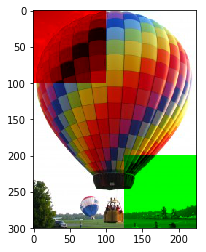

In [10]:
color_patches = color_image.copy()
# Remove green (1) & blue (2) from top-left corner.
color_patches[:100, :100, 1:] = 0
# Remove red (0) & blue (2) from bottom-right corner.
color_patches[-100:, -100:, (0, 2)] = 0
plt.imshow(color_patches);

## Histograms

Histograms are a quick way to get a feel for the global statistics of the image intensity. For example, they can tell you where to set a threshold or how to adjust the contrast of an image.

You might be inclined to plot a histogram using matplotlib's `hist` function:

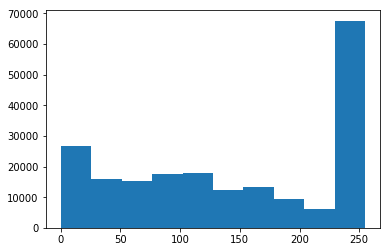

In [14]:
plt.hist(color_image.flatten());

That didn't work as expected. How would you fix the call above to make it work correctly?
(Hint: that's a 2-D array, ``numpy.ravel``)

---

### Histograms of images

For this section, we're going to use a custom plotting function that adds a few tweaks to pretty-it-up:
* Plot the image next to the histogram
* Plot each RGB channel separately
* Automatically flatten channels
* Select reasonable bins based on the image's `dtype`

In [15]:
skdemo.imshow_with_histogram?

Using this function, let's look at the histogram of a grayscale image:

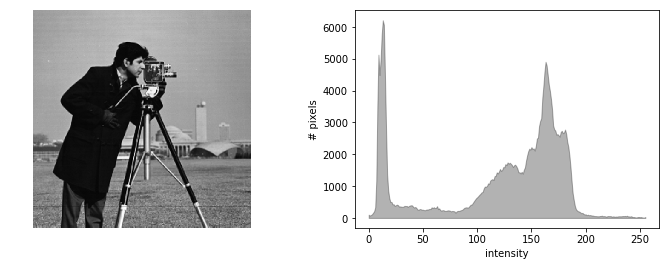

In [16]:
image = data.camera()
skdemo.imshow_with_histogram(image);

An image histogram shows the number of pixels at each intensity value (or range of intensity values, if values are binned). Low-intensity values are closer to black, and high-intensity values are closer to white.

Notice that there's a large peak at an intensity of about 10: This peak corresponds with the man's nearly black coat. The peak around the middle of the histogram is due to the predominantly gray tone of the image.

Now let's look at our color image:

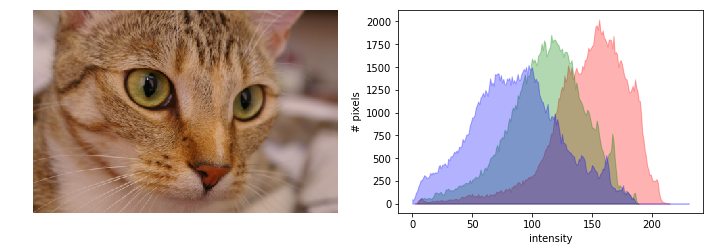

In [17]:
cat = data.chelsea()
skdemo.imshow_with_histogram(cat);

As you can see, the intensity for each RGB channel is plotted separately. Unlike the previous histogram, these histograms almost look like Gaussian distributions that are shifted. This reflects the fact that intensity changes are relatively gradual in this picture: There aren't very many uniform instensity regions in this image.

**Note:** While RGB histograms are pretty, they are often not very intuitive or useful, since a high red value is very different when combined with *low* green/blue values (the result will tend toward red) vs *high* green and blue values (the result will tend toward white).

### Histograms and contrast

Enhancing the contrast of an image allow us to more easily identify features in an image, both by eye and by detection algorithms.

Let's take another look at the gray-scale image from earlier:

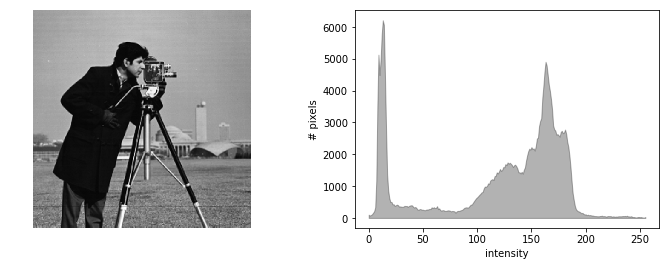

In [18]:
image = data.camera()
skdemo.imshow_with_histogram(image);

Notice the intensity values at the bottom. Since the image has a `dtype` of `uint8`, the values go from 0 to 255. Though you can see some pixels tail off toward 255, you can clearly see in the histogram, and in the image, that we're not using the high-intensity limits very well.

Based on the histogram values, you might want to take all the pixels values that are more than about 180 in the image, and make them pure white (i.e. an intensity of 255). While we're at it, values less than about 10 can be set to pure black (i.e. 0). We can do this easily using `rescale_intensity`, from the `exposure` subpackage.

In [19]:
from skimage import exposure
high_contrast = exposure.rescale_intensity(image, in_range=(10, 180))

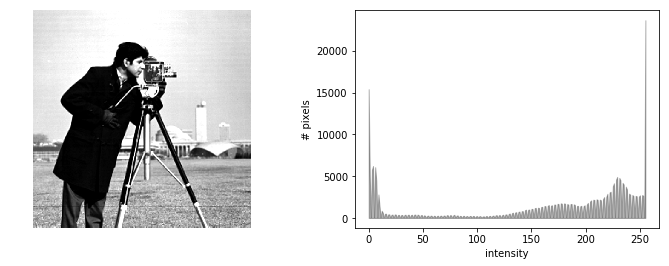

In [20]:
skdemo.imshow_with_histogram(high_contrast);

The contrast is visibly higher in the image, and the histogram is noticeably stretched. The sharp peak on the right is due to all the pixels greater than 180 (in the original image) that were piled into a single bin (i.e. 255).

In [21]:
exposure.rescale_intensity?

Parameters for `rescale_intensity`:
* `in_range`: The min and max intensity values desired in the input image. Values below/above these limits will be clipped.
* `out_range`: The min and max intensity values of the output image. Pixels matching the limits from `in_range` will be rescaled to these limits. Everything in between gets linearly interpolated.

### Histogram equalization

In the previous example, the grayscale values (10, 180) were set to (0, 255), and everything in between was linearly interpolated. There are other strategies for contrast enhancement that try to be a bit more intelligent---notably histogram equalization.

Let's first look at the cumulative distribution function (CDF) of the image intensities.

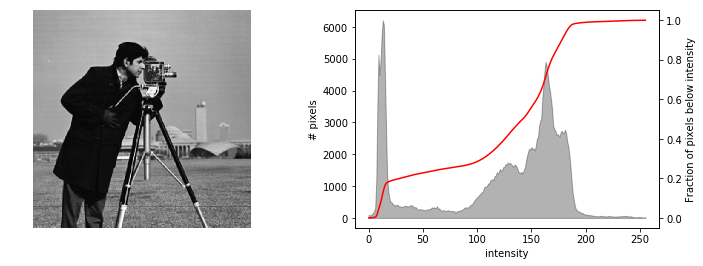

In [22]:
ax_image, ax_hist = skdemo.imshow_with_histogram(image)
skdemo.plot_cdf(image, ax=ax_hist.twinx())

For each intensity value, the CDF gives the fraction of pixels *below* that intensity value.

One measure of contrast is how evenly distributed intensity values are: The dark coat might contrast sharply with the background, but the tight distribution of pixels in the dark coat mean that details in the coat are hidden.

To enhance contrast, we could *spread out intensities* that are tightly distributed and *combine intensities* which are used by only a few pixels.

This redistribution is exactly what histogram equalization does. And the CDF is important because a perfectly uniform distribution gives a CDF that's a straight line. We can use `equalize_hist` from the `exposure` package to produce an equalized image:

In [23]:
equalized = exposure.equalize_hist(image)

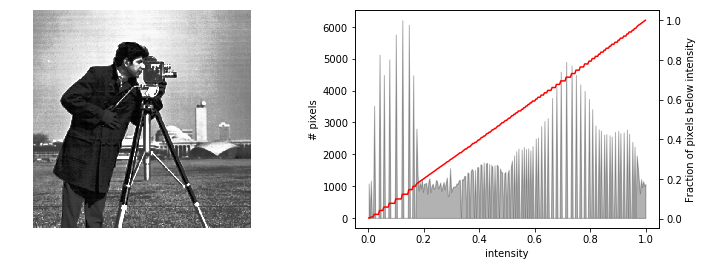

In [24]:
ax_image, ax_hist = skdemo.imshow_with_histogram(equalized)
skdemo.plot_cdf(equalized, ax=ax_hist.twinx())

The tightly distributed dark-pixels in the coat have been spread out, which reveals many details in the coat that were missed earlier. As promised, this more even distribution produces a CDF that approximates a straight line.

Notice that the image intensities switch from 0--255 to 0.0--1.0:

In [25]:
equalized.dtype

dtype('float64')

Functions in `scikit-image` allow any data-type as an input, but the output data-type may change depending on the algorithm. While `uint8` is really efficient in terms of storage, we'll see in the next section that computations using `uint8` images can be problematic in certain cases.

If you need a specific data-type, check out the image conversion functions in scikit image:

In [26]:
import skimage

#skimage.img_as  # <TAB>

### Contrasted-limited, adaptive histogram equalization

Unfortunately, histogram equalization tends to give an image whose contrast is artificially high. In addition, better enhancement can be achieved locally by looking at smaller patches of an image, rather than the whole image. In the image above, the contrast in the coat is much improved, but the contrast in the grass is somewhat reduced.

Contrast-limited adaptive histogram equalization (CLAHE) addresses these issues. The implementation details aren't too important, but seeing the result is helpful:

In [27]:
equalized = exposure.equalize_adapthist(image)

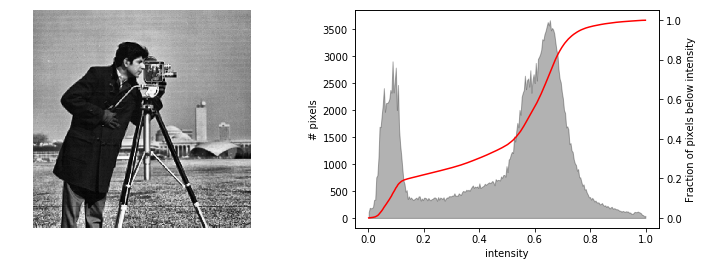

In [28]:
ax_image, ax_hist = skdemo.imshow_with_histogram(equalized)
skdemo.plot_cdf(equalized, ax=ax_hist.twinx())

Compared to plain-old histogram equalization, the high contrast in the coat is maintained, but the contrast in the grass is also improved. 
Furthermore, the contrast doesn't look overly-enhanced, as it did with the standard histogram equalization.

Again, notice that the output data-type is different than our input. This time, we have a `uint16` image, which is another common format for images:

In [29]:
equalized.dtype

dtype('float64')

There's a bit more tweaking involved in using `equalize_adapthist` than in `equalize_hist`: Input parameters are used to control the patch-size and contrast enhancement. You can learn more by checking out the docstring:

In [30]:
exposure.equalize_adapthist?

### Histograms and thresholding

One of the most common uses for image histograms is thresholding. Let's return to the original image and its histogram

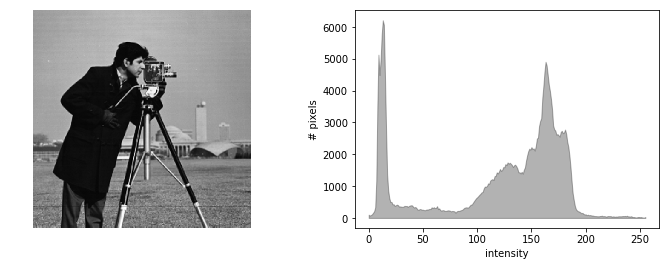

In [31]:
skdemo.imshow_with_histogram(image);

Here the man and the tripod are fairly close to black, and the rest of the scene is mostly gray. But if you wanted to separate the two, how do you decide on a threshold value just based on the image? Looking at the histogram, it's pretty clear that a value of about 50 will separate the two large portions of this image.

In [32]:
threshold = 50

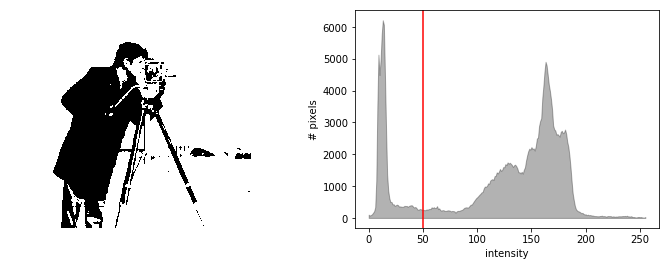

In [33]:
ax_image, ax_hist = skdemo.imshow_with_histogram(image)
# This is a bit of a hack that plots the thresholded image over the original.
# This just allows us to reuse the layout defined in `plot_image_with_histogram`.
ax_image.imshow(image > threshold)
ax_hist.axvline(threshold, color='red');

Note that the histogram plotted here is for the image *before* thresholding.

This does a pretty good job of separating the man (and tripod) from most of the background. Thresholding is the simplest method of image segmentation; i.e. dividing an image into "meaningful" regions. More on that later.

As you might expect, you don't have to look at a histogram to decide what a good threshold value is: There are (many) algorithms that can do it for you. For historical reasons, `scikit-image` puts these functions in the `filter` module.

One of the most popular thresholding methods is Otsu's method, which gives a slightly different threshold than the one we defined above:

In [35]:
# Rename module so we don't shadow the builtin function
import skimage.filters as filters
threshold = filters.threshold_otsu(image)
print(threshold)

87


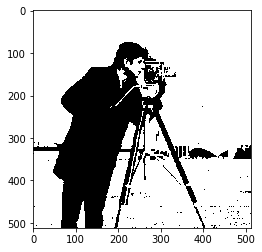

In [36]:
plt.imshow(image > threshold);

Note that the features of the man's face are slightly better resolved in this case.

You can find a few other thresholding methods in the `filter` module:

In [39]:
import skimage.filters as filters
#filters.threshold  # <TAB>

## Color spaces

While RGB is fairly easy to understand, using it to detect a specific color (other than red, green, or blue) can be a pain. Other color spaces often devote a single component to the image intensity (a.k.a. luminance, lightness, or value) and two components to represent the color (e.g. hue and saturation in [HSL and HSV](http://en.wikipedia.org/wiki/HSL_and_HSV)).

You can easily convert to a different color representation, or "color space", using functions in the `color` module.

In [40]:
from skimage import color
#color.rgb2  # <TAB>

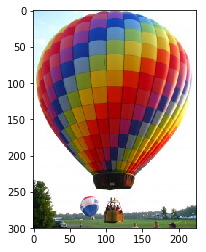

In [41]:
plt.imshow(color_image);

Here, we'll look at the LAB (a.k.a. CIELAB) color space (`L` = luminance, `a` and `b` define a 2D description of the actual color or "hue"):

In [42]:
from skimage import color

lab_image = color.rgb2lab(color_image)
lab_image.shape

(300, 225, 3)

Converting to LAB didn't change the shape of the image at all. Let's try to plot it:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


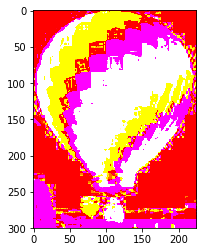

In [43]:
plt.imshow(lab_image);

Matplotlib expected an RGB array, and apparently, LAB arrays don't look anything like RGB arrays.

That said, there is some resemblance to the original.

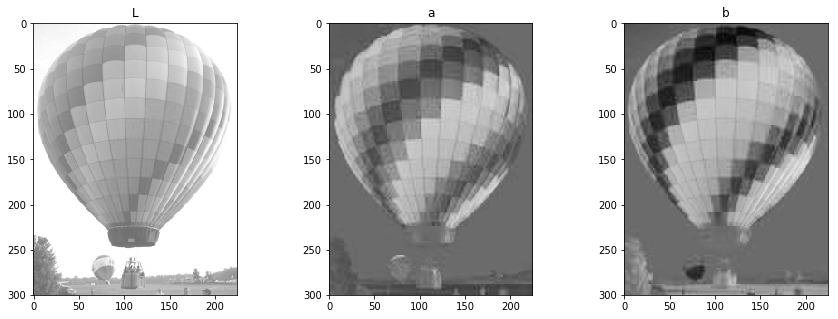

In [44]:
skdemo.imshow_all(lab_image[..., 0], lab_image[..., 1], lab_image[..., 2],
                 titles=['L', 'a', 'b'])

Lab gamut, showing only sRGB colors:
<img src="Lab_color_space.svg" width="40%"/>
Image <a href="https://commons.wikimedia.org/wiki/File:Lab_color_space.svg">licensed CC BY-SA by Jacob Rus</a>

Lab is more perceptually uniform than sRGB--better approximates human vision, but there are even better options.

---

## <span class="exercize">Fun with film</span>

In the film industry, it is often necessary to impose actors on top of a rendered background.  To do that, the actors are filmed on a "green screen".  Here's an example shot (``images/greenscreen.jpg``):

<img src="../images/greenscreen.jpg" width="300px"/>

Say we'd like to help these friendly folk travel into a rainforest (``images/forest.jpg``):

<img src="../images/forest.jpg" width="300px"/>

Can you help them by transplanting the foreground of the greenscreen onto the backdrop of the forest?

## <span class="exercize">Exploring color spaces</span>

1. Decompose the Balloon image of earlier into its H, S and V (hue, saturation, value) color components.  Display each component and interpret the result.

2. Use the LAB color space to **isolate the eyes** in the `chelsea` image. Plot the L, a, b components to get a feel for what they do, and see the [wikipedia page](http://en.wikipedia.org/wiki/Lab_colorspace) for more info. Bonus: **Isolate the nose** too.

In [45]:
# Your code here

---

## Further reading

* [Example of tinting gray-scale images](<http://scikit-image.org/docs/dev/auto_examples/plot_tinting_grayscale_images.html>)
* Color spaces (see [`skimage.color`](http://scikit-image.org/docs/dev/api/skimage.color.html) package)
  - `rgb2hsv`
  - `rgb2luv`
  - `rgb2xyz`
  - `rgb2lab`
* [Histogram equalization](http://scikit-image.org/docs/dev/auto_examples/plot_equalize.html) and [local histogram equalization](http://scikit-image.org/docs/dev/auto_examples/plot_local_equalize.html)

In [47]:
#%reload_ext load_style
#%load_style ../themes/tutorial.css